# About timeline_viz.ipynb

This notebook uses the functions defined and demontrasted in *utils_timeline_viz.ipynb* to clean log data and visualize it.
This is a work in progress :)

In [1]:
exec(open('load_utils.py').read())
from utils_timeline_viz import *

importing notebook from utils_timeline_viz.ipynb
importing function: find_student_log_file
importing function: remove_model_events
importing function: calculate_duration
importing function: prep_parsing_data
importing function: add_family
importing function: get_blocks_withTime
importing function: plot_barGraph_new
importing function: family_usage
importing function: plot


In [2]:
studentid = '83459165'
sim = 'beers'
# parsed_file = find_student_log_file(FOLDER,sim,studentid)
parsed_file = 'dream_table_beers-law-lab_83459165_2017-01-13_14.26.08.txt'
df2 = prep_parsing_data(parsed_file)

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [3]:
family_name_to_code = {'Interface':'I',
                        'Pause':'P',
                        'Graph (add/del/edit)':'G',
                        'Data Table (del/move)':'Dt',
                        'Notes':'N',
                        'Record':'M',
                        'Detector':'Vd',
                        'Wavelength':'Vw',
                        'Width':'Vc',
                        'Concentration':'Vs',
                        'Laser toggle':'Vl',
                        }

function_to_use = {}

to_plot = ['Interface','Notes','Pause','Graph (add/del/edit)','Data Table (del/move)','Record','Detector','Wavelength','Width','Concentration','Laser toggle']

In [4]:
def plot(df,to_plot,family_name_to_code,function_to_use):
    ax = plt.subplot()
    spacing = 10
    margin = 1
    max_time = 0
    colors = sns.color_palette("hls", len(to_plot))
    
    for i,action in enumerate(to_plot):
        if action in family_name_to_code.keys():
            action_use = family_usage(df,'Family',family_name_to_code[action])
            action_use = clean_coords(action_use)
        else:
            action_use = function_to_use[action](df)

            
        if action_use:
            if action in ['Pause','Notes','Record']:
                    ax.broken_barh(action_use,(i*spacing,(spacing)*(len(to_plot)-i)),facecolors=colors[i],linewidth=0.5,edgecolor='k',alpha=0.4)
            max_time = max(max_time,sum(action_use[-1]))
            ax.broken_barh(action_use,(i*spacing,(spacing-margin)),facecolors=colors[i],alpha=1,linewidth=0.5,edgecolor='k')

    #Shape plot
    ax.set_ylim(-2, len(to_plot)*spacing+2)
    ax.set_xlim(0, max_time+2)
    
    #Add labels
    ax.set_xlabel('Time (min)',fontsize=25)
    ax.set_xticks(range(0,int(max_time),60))
    ax.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=13)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(spacing/2,len(to_plot)*spacing,spacing))
    ax.set_yticklabels([a.capitalize() for a in to_plot],fontsize=25)
    ax.grid(True)

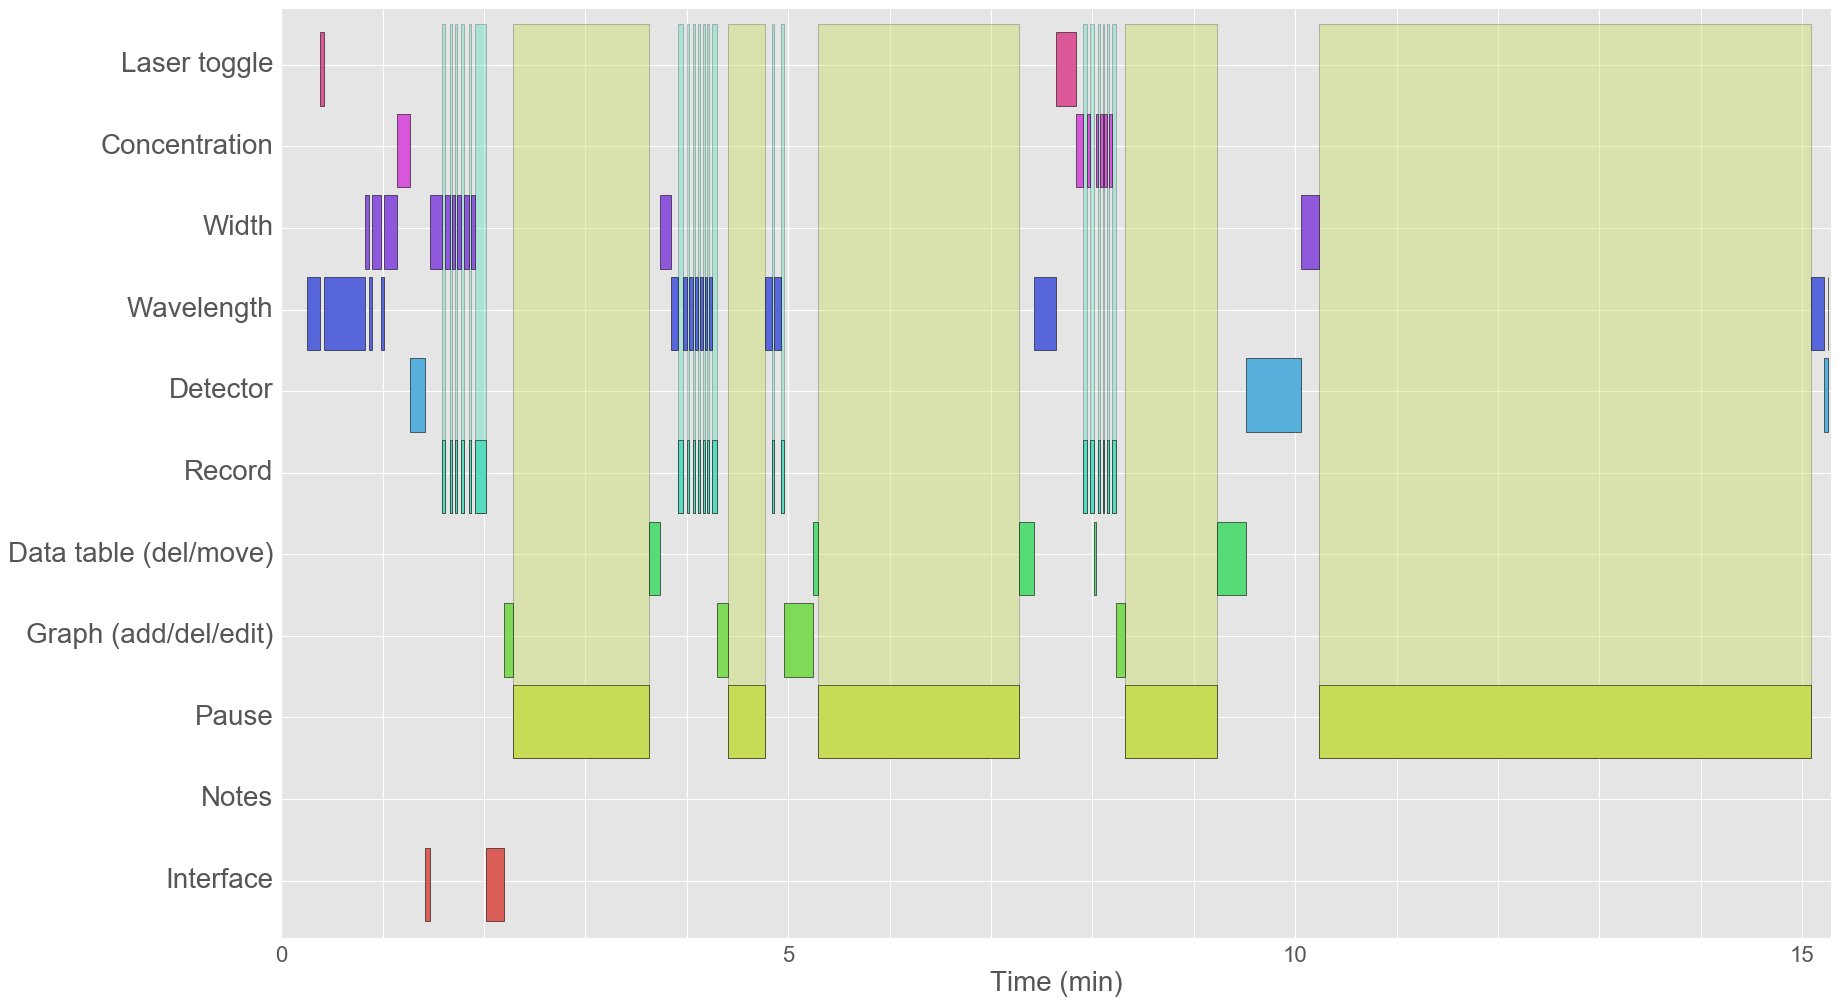

In [5]:
plot(df2,to_plot,family_name_to_code,function_to_use)